In [1]:
#importing the required packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy,AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from tensorflow.keras.optimizers import Adam
import itertools
import cv2
import scipy.integrate as integrate
import scipy
from tensorflow.keras.applications import VGG16,VGG19,ResNet50,ResNet101, ResNet152,InceptionResNetV2,inception_v3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

## Importing Images

In [2]:
data_dir = "D:\AI_Projects\TB\Dataset"
categories = ["Normal", "Tuberculosis"]

In [3]:
#resizing images
img_size = (256, 256)  
data = []

In [4]:
for category_id, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, img_size)
        data.append([img_array, category_id])

data = shuffle(data)

In [5]:
X = np.array([x[0] for x in data]).reshape(-1, img_size[0], img_size[1], 1)
y = np.array([x[1] for x in data])

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

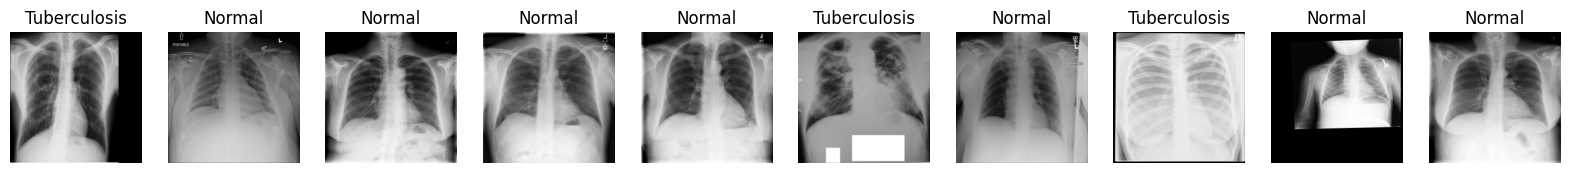

In [6]:
def plot_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(img_size), cmap='gray')
        axes[i].set_title(categories[labels[i]])
        axes[i].axis('off')
    plt.show()
    
plot_images(X_train, y_train)

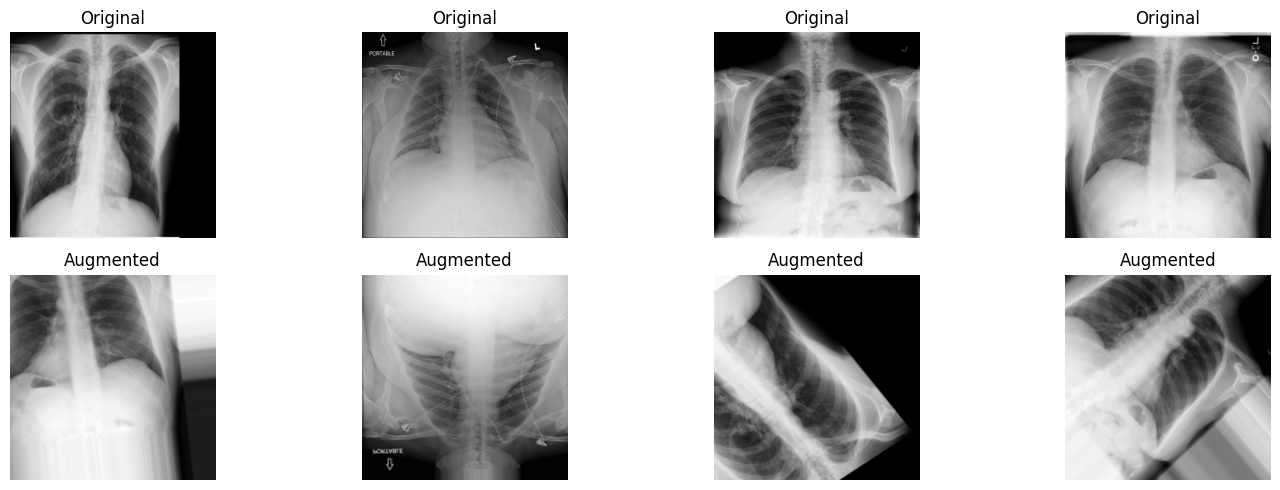

In [7]:
datagen = ImageDataGenerator(
    rotation_range=60,  # Random rotation in the range of 0-60 degrees
    width_shift_range=0.2,  # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=True,  # Random vertical flipping
    fill_mode='nearest'  
)

datagen.fit(X_train)

def plot_original_and_augmented(original_images, augmented_images, labels, num_images=4):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        axes[0, i].imshow(original_images[i].reshape(img_size), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(augmented_images[i].reshape(img_size), cmap='gray')
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


batch_size = 4  
num_augmented = 2  

augmented_generator = datagen.flow(X_train[:batch_size], y_train[:batch_size], batch_size=batch_size)

augmented_images, _ = next(augmented_generator)

plot_original_and_augmented(X_train[:batch_size], augmented_images, [y_train[0]] * batch_size)



In [8]:
num_train_samples = X_train.shape[0]
num_val_samples = X_val.shape[0]
num_test_samples = X_test.shape[0]

print("Number of samples in training set:", num_train_samples)
print("Number of samples in validation set:", num_val_samples)
print("Number of samples in testing set:", num_test_samples)

num_normal_samples = np.sum(y_train == 0) + np.sum(y_val == 0) + np.sum(y_test == 0)
num_infected_samples = np.sum(y_train == 1) + np.sum(y_val == 1) + np.sum(y_test == 1)

print("Number of TB_normal samples:", num_normal_samples)
print("Number of TB_infected samples:", num_infected_samples)


Number of samples in training set: 2688
Number of samples in validation set: 672
Number of samples in testing set: 840
Number of TB_normal samples: 3500
Number of TB_infected samples: 700


In [9]:
def count_samples_per_class(y):
    num_classes = np.max(y) + 1
    class_counts = np.zeros(num_classes, dtype=int)
    for i in range(num_classes):
        class_counts[i] = np.sum(y == i)
    return class_counts

train_class_counts = count_samples_per_class(y_train)
print("Number of samples per class in training set:")
for i, count in enumerate(train_class_counts):
    print(f"Class {i}: {count}")

val_class_counts = count_samples_per_class(y_val)
print("\nNumber of samples per class in validation set:")
for i, count in enumerate(val_class_counts):
    print(f"Class {i}: {count}")

test_class_counts = count_samples_per_class(y_test)
print("\nNumber of samples per class in testing set:")
for i, count in enumerate(test_class_counts):
    print(f"Class {i}: {count}")

Number of samples per class in training set:
Class 0: 2236
Class 1: 452

Number of samples per class in validation set:
Class 0: 565
Class 1: 107

Number of samples per class in testing set:
Class 0: 699
Class 1: 141


In [10]:
class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

num_images_to_augment_class_0 = int(0.01 * len(class_0_indices)) 
num_images_to_augment_class_1 = int(0.5 * len(class_1_indices)) 

indices_to_augment_class_0 = np.random.choice(class_0_indices, num_images_to_augment_class_0, replace=False)
indices_to_augment_class_1 = np.random.choice(class_1_indices, num_images_to_augment_class_1, replace=False)

augmented_train_data = []
augmented_train_labels = []

for i in indices_to_augment_class_0:
    sample = X_train[i].reshape((1,) + X_train[i].shape)  
    augmented_samples = datagen.flow(sample, batch_size=1)
    for batch in augmented_samples:
        augmented_train_data.append(batch[0])
        augmented_train_labels.append(y_train[i])
        break

for i in indices_to_augment_class_1:
    sample = X_train[i].reshape((1,) + X_train[i].shape)  
    augmented_samples = datagen.flow(sample, batch_size=1)
    for batch in augmented_samples:
        augmented_train_data.append(batch[0])
        augmented_train_labels.append(y_train[i])
        break

augmented_train_data = np.array(augmented_train_data)
augmented_train_labels = np.array(augmented_train_labels)

X_train_augmented = np.concatenate((X_train, augmented_train_data))
y_train_augmented = np.concatenate((y_train, augmented_train_labels))

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

augmented_train_class_counts = count_samples_per_class(y_train_augmented)
print("Number of samples per class in augmented training set:")
for i, count in enumerate(augmented_train_class_counts):
    print(f"Class {i}: {count}")

Number of samples per class in augmented training set:
Class 0: 2258
Class 1: 678


In [11]:
X_train_rgb = np.repeat(X_train_augmented[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, axis=-1)
X_train_real = np.repeat(X_train[..., np.newaxis], 3, axis=-1)

X_train_rgb = np.squeeze(X_train_rgb, axis=-2)
X_val_rgb = np.squeeze(X_val_rgb, axis=-2)
X_test_rgb = np.squeeze(X_test_rgb, axis=-2)
X_train_real = np.squeeze(X_train_real, axis=-2)

In [12]:
y_train_real = np.repeat(y_train[..., np.newaxis], 3, axis=-1)

In [13]:
y_train_augmented.shape, y_train.shape

((2936,), (2688,))

## VGG 16

In [12]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg16.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg16)

# Adding new layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
y_train_augmented = to_categorical(y_train_augmented)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#y_test = to_categorical(y_test)

In [15]:
print(X_train_rgb.shape, y_train_augmented.shape,y_train.shape,X_train_real.shape,y_val.shape,X_val_rgb.shape)

(2936, 256, 256, 3) (2936, 2) (2688, 2) (2688, 256, 256, 3) (672, 2) (672, 256, 256, 3)


In [16]:
#training
history = model.fit(X_train_rgb, y_train_augmented, epochs=15, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9955 - val_loss: 0.0084
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9955 - val_loss: 0.0074
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9940 - val_loss: 0.0126
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 1.0000 - loss: 9.1053e-04 - val_accuracy: 0.9955 - val_loss: 0.0093
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 1.0000 - loss: 4.9881e-04 - val_accuracy: 0.9955 - val_loss: 0.0102
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 1.0000 - loss: 4.8933e-04 - val_accuracy: 0.9970 - val_loss: 0.0053
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 1.0000 - loss: 5.1432e-04 - val_accuracy: 0.9955 - val_loss: 0.0070
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 1.0000 - loss: 5.0913e-04 - val_

27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step


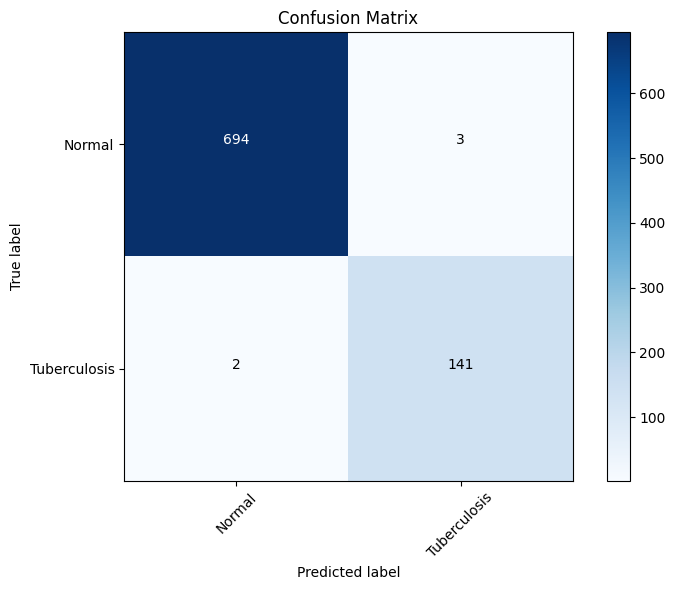

In [22]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [23]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 99.4048
Precision: 97.9167
Recall: 98.6014
F-Score: 98.2578


In [24]:
y_pred_prob = model.predict(X_test_rgb)

if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_pred_prob = y_pred_prob[:, 1]

auc_score = roc_auc_score(y_test, y_pred_prob)

print('AUC score:', auc_score)

27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
AUC score: 0.9993930029798036


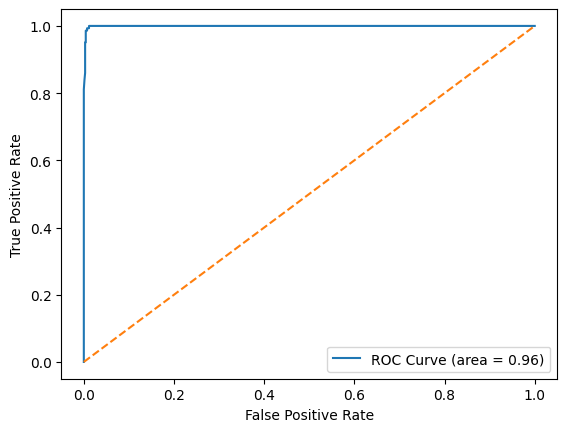

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC Curve (area = 0.96)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('AUC.pdf',format='pdf',bbox_inches='tight')
plt.show()



In [ ]:
model.save(os.path.join('models','vgg-16.h5'))

In [ ]:
new_model = load_model('./models/vgg-16-au.h5')

In [21]:
# real images
history = model.fit(X_train_real, y_train, epochs=15, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 1.0000 - loss: 1.3583e-04 - val_accuracy: 0.9955 - val_loss: 0.0066
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 1.0000 - loss: 1.3626e-04 - val_accuracy: 0.9955 - val_loss: 0.0086
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 1.0000 - loss: 9.5411e-05 - val_accuracy: 0.9955 - val_loss: 0.0088
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 1.0000 - loss: 9.0203e-05 - val_accuracy: 0.9955 - val_loss: 0.0070
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 1.0000 - loss: 9.2563e-05 - val_accuracy: 0.9955 - val_loss: 0.0073
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 1.0000 - loss: 1.0989e-04 - val_accuracy: 0.9940 - val_loss: 0.0187
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 339s 4s/step - accuracy: 1.0000 - loss: 2.0909e-04 - val_accuracy: 0.9955 - val_loss: 0.0099
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 1.0000 - loss: 6.956

## VGG 19

In [27]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19)

# Adding new layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [28]:
#training
history = model.fit(X_train_rgb, y_train_augmented, epochs=15, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 450s 5s/step - accuracy: 0.8607 - loss: 1.4332 - val_accuracy: 0.9836 - val_loss: 0.0292
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.9801 - loss: 0.0583 - val_accuracy: 0.9896 - val_loss: 0.0210
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.9885 - loss: 0.0287 - val_accuracy: 0.9821 - val_loss: 0.0496
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.9859 - loss: 0.0407 - val_accuracy: 0.9970 - val_loss: 0.0172
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 0.9940 - val_loss: 0.0186
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.9969 - loss: 0.0112 - val_accuracy: 0.9955 - val_loss: 0.0110
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9970 - val_loss: 0.0125
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9970 - v

27/27 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step


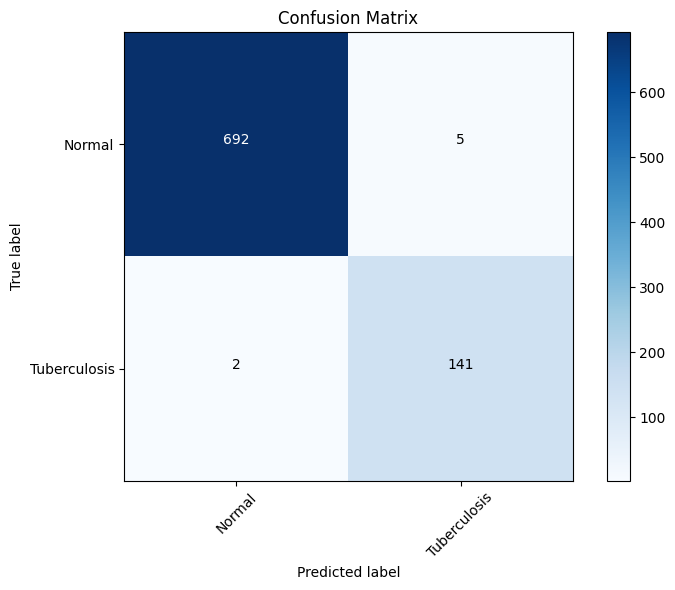

In [35]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [36]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 99.1667
Precision: 96.5753
Recall: 98.6014
F-Score: 97.5779


In [37]:
y_pred_prob = model.predict(X_test_rgb)

if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_pred_prob = y_pred_prob[:, 1]

auc_score = roc_auc_score(y_test, y_pred_prob)

print('AUC score:', auc_score)

27/27 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step
AUC score: 0.9989766331229746


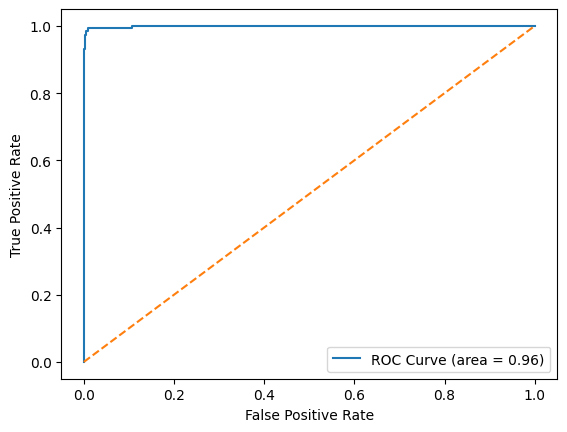

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC Curve (area = 0.96)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('AUC.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [ ]:
model.save(os.path.join('models','vgg-19-aug.h5'))

In [34]:
#training
history = model.fit(X_train_rgb, y_train_augmented, epochs=15, batch_size=32, validation_data=(X_val_rgb, y_val))

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 439s 5s/step - accuracy: 1.0000 - loss: 1.7508e-04 - val_accuracy: 0.9985 - val_loss: 0.0064
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 449s 5s/step - accuracy: 1.0000 - loss: 1.4356e-04 - val_accuracy: 0.9955 - val_loss: 0.0076
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - accuracy: 1.0000 - loss: 1.2237e-04 - val_accuracy: 0.9985 - val_loss: 0.0065
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 454s 5s/step - accuracy: 1.0000 - loss: 1.2939e-04 - val_accuracy: 0.9955 - val_loss: 0.0084
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 1.0000 - loss: 1.0171e-04 - val_accuracy: 0.9985 - val_loss: 0.0051
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 455s 5s/step - accuracy: 1.0000 - loss: 1.2195e-04 - val_accuracy: 0.9955 - val_loss: 0.0112
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 456s 5s/step - accuracy: 1.0000 - loss: 9.0161e-05 - val_accuracy: 0.9955 - val_loss: 0.0071
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 1.0000 - loss: 7.419

## RESNET 50

In [15]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet50.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet50)

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.3))         

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
history = model.fit(X_train_rgb, y_train_augmented, epochs=100, batch_size=16, validation_data=(X_val_rgb, y_val))

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 180s 939ms/step - accuracy: 0.7596 - loss: 0.5877 - val_accuracy: 0.4107 - val_loss: 1.3006
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 175s 950ms/step - accuracy: 0.8941 - loss: 0.2912 - val_accuracy: 0.5655 - val_loss: 0.8572
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 179s 976ms/step - accuracy: 0.9201 - loss: 0.2455 - val_accuracy: 0.8185 - val_loss: 1.7734
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9388 - loss: 0.1678 - val_accuracy: 0.4286 - val_loss: 1.3049
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 180s 978ms/step - accuracy: 0.9511 - loss: 0.1349 - val_accuracy: 0.7515 - val_loss: 0.6787
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 183s 993ms/step - accuracy: 0.9566 - loss: 0.1252 - val_accuracy: 0.9420 - val_loss: 0.2208
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9462 - loss: 0.1322 - val_accuracy: 0.9241 - val_loss: 0.2459
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 183s 995ms/step - accuracy: 0.9543

27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step


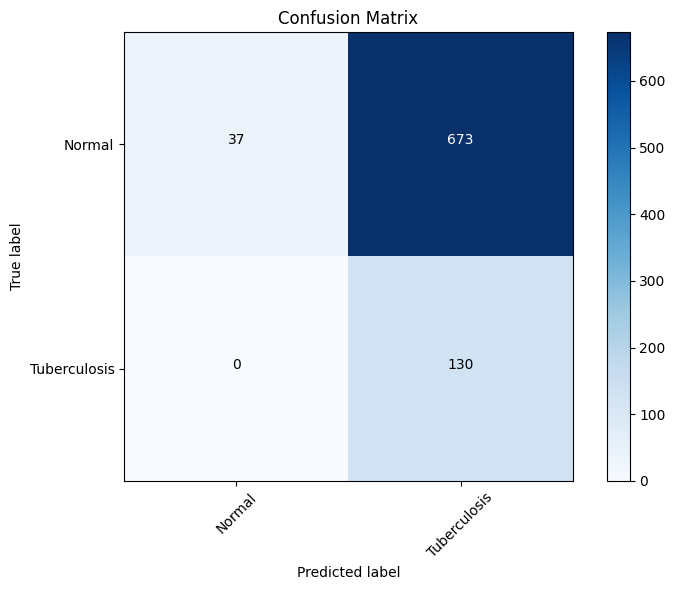

In [42]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [36]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 96.9048
Precision: 94.8276
Recall: 84.6154
F-Score: 89.4309


In [19]:
y_pred_prob = model.predict(X_test_rgb)

if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_pred_prob = y_pred_prob[:, 1]

auc_score = roc_auc_score(y_test, y_pred_prob)

print('AUC score:', auc_score)

27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
AUC score: 0.986771397616468


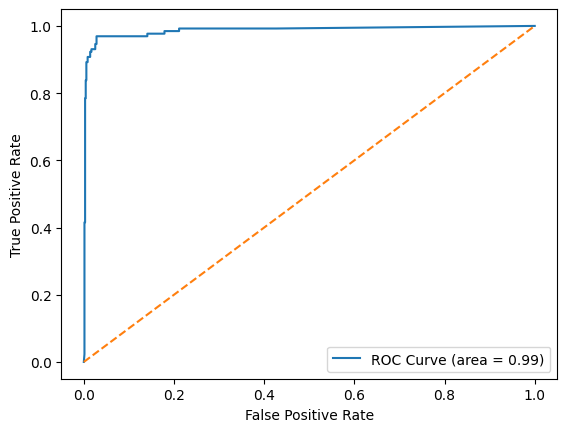

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label='ROC Curve (area = 0.99)')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('AUC.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [25]:
# real images
history = model.fit(X_train_real, y_train, epochs=100, batch_size=16, validation_data=(X_val_rgb, y_val))

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 159s 948ms/step - accuracy: 0.9915 - loss: 0.0270 - val_accuracy: 0.9792 - val_loss: 0.1025
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 167s 995ms/step - accuracy: 0.9967 - loss: 0.0121 - val_accuracy: 0.6384 - val_loss: 1.9070
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9449 - val_loss: 0.2825
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9122 - val_loss: 0.5820
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9965 - loss: 0.0078 - val_accuracy: 0.8199 - val_loss: 20.3419
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9929 - loss: 0.0226 - val_accuracy: 0.7783 - val_loss: 1.3869
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.8571 - val_loss: 1.3906
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9973 - loss: 0.

# ResNet 101

In [29]:
resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet101.layers:
    layer.trainable = False

model = Sequential()
model.add(resnet101)

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization()) 
model.add(Dropout(0.3))         

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ ?                           │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [30]:
history = model.fit(X_train_rgb, y_train_augmented, epochs=100, batch_size=16, validation_data=(X_val_rgb, y_val))

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.7658 - loss: 0.5935 - val_accuracy: 0.1815 - val_loss: 28.9948
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8856 - loss: 0.3092 - val_accuracy: 0.9360 - val_loss: 0.2336
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9179 - loss: 0.2306 - val_accuracy: 0.9509 - val_loss: 0.1696
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9272 - loss: 0.1958 - val_accuracy: 0.8631 - val_loss: 0.5946
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9384 - loss: 0.1730 - val_accuracy: 0.8229 - val_loss: 1.5046
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9471 - loss: 0.1420 - val_accuracy: 0.9420 - val_loss: 0.1464
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.9459 - loss: 0.1389 - val_accuracy: 0.9152 - val_loss: 0.1901
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9553 - loss: 0.1280 -

In [34]:
# real images
history = model.fit(X_train_real, y_train, epochs=100, batch_size=16, validation_data=(X_val_rgb, y_val))

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.9942 - loss: 0.0206 - val_accuracy: 0.8423 - val_loss: 4.5038
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.6637 - val_loss: 1.6251
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9935 - loss: 0.0163 - val_accuracy: 0.9494 - val_loss: 0.1416
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9979 - loss: 0.0104 - val_accuracy: 0.8676 - val_loss: 1.3362
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9912 - loss: 0.0381 - val_accuracy: 0.9167 - val_loss: 0.2245
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 0.9598 - val_loss: 0.1469
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9950 - loss: 0.0127 - val_accuracy: 0.9747 - val_loss: 0.1098
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9949 - loss: 0.0130 - 

# ResNet152

In [16]:
y_train_integers = np.argmax(y_train_augmented, axis=1)

# Computing class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weights = dict(enumerate(class_weights))

resnet152 = ResNet152(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Fining-tune some of the deeper layers
for layer in resnet152.layers[:-10]:
    layer.trainable = False
for layer in resnet152.layers[-10:]:
    layer.trainable = True

model = Sequential()
model.add(resnet152)

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35)) 

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3)) 

model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)               │ ?                           │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 4,465,664 (17.04 MB)

 Non-trainable params: 53,905,280 (205.63 MB)

In [19]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_rgb, 
    y_train_augmented, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val_rgb, y_val), 
    class_weight=class_weights, 
    callbacks=[lr_scheduler]
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.6766 - loss: 0.6359 - precision: 0.6766 - recall: 0.6766 - val_accuracy: 0.2708 - val_loss: 0.9118 - val_precision: 0.2708 - val_recall: 0.2708 - learning_rate: 1.0000e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.7933 - loss: 0.4387 - precision: 0.7933 - recall: 0.7933 - val_accuracy: 0.9018 - val_loss: 0.2482 - val_precision: 0.9018 - val_recall: 0.9018 - learning_rate: 1.0000e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.8359 - loss: 0.3515 - precision: 0.8359 - recall: 0.8359 - val_accuracy: 0.8914 - val_loss: 0.3121 - val_precision: 0.8914 - val_recall: 0.8914 - learning_rate: 1.0000e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.8742 - loss: 0.3082 - precision: 0.8742 - recall: 0.8742 - val_accuracy: 0.5000 - val_loss: 1.0231 - val_precision: 0.5000 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 415s

27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step


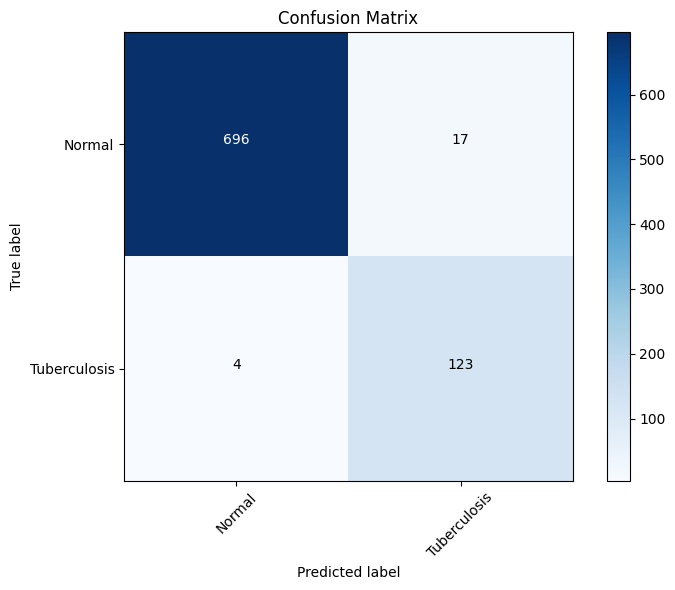

In [20]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [19]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 97.8571
Precision: 93.617
Recall: 93.617
F-Score: 93.617


In [17]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# real images
history = model.fit(
    X_train_real, 
    y_train, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val_rgb, y_val), 
    class_weight=class_weights, 
    callbacks=[lr_scheduler]
)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.6189 - loss: 0.7006 - precision: 0.6189 - recall: 0.6189 - val_accuracy: 0.1592 - val_loss: 1.6772 - val_precision: 0.1592 - val_recall: 0.1592 - learning_rate: 1.0000e-04
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.7410 - loss: 0.4599 - precision: 0.7410 - recall: 0.7410 - val_accuracy: 0.1726 - val_loss: 2.1040 - val_precision: 0.1726 - val_recall: 0.1726 - learning_rate: 1.0000e-04
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - accuracy: 0.8277 - loss: 0.3510 - precision: 0.8277 - recall: 0.8277 - val_accuracy: 0.7411 - val_loss: 0.7091 - val_precision: 0.7411 - val_recall: 0.7411 - learning_rate: 1.0000e-04
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.8512 - loss: 0.3305 - precision: 0.8512 - recall: 0.8512 - val_accuracy: 0.1622 - val_loss: 3.5677 - val_precision: 0.1622 - val_recall: 0.1622 - learning_rate: 1.0000e-04
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 430s

27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step


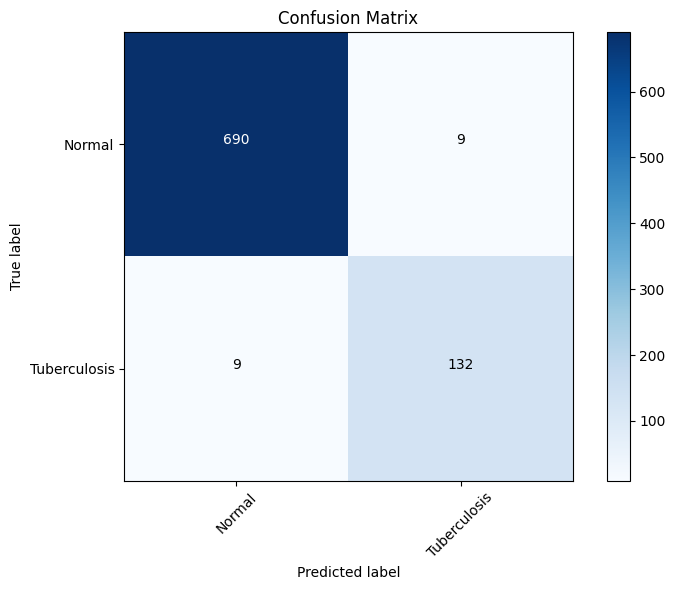

In [18]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Inception Resnet V2

In [21]:
inception_resnet_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in inception_resnet_v2.layers[:-10]:
    layer.trainable = False
for layer in inception_resnet_v2.layers[-10:]:
    layer.trainable = True

model = Sequential()
model.add(inception_resnet_v2)

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))  

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  

model.add(Dense(units=2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ ?                           │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_206              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_207              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_208              │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 4,130,784 (15.76 MB)

 Non-trainable params: 50,205,952 (191.52 MB)

In [22]:

y_train_integers = np.argmax(y_train_augmented, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weights = dict(enumerate(class_weights))

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


In [23]:
history = model.fit(
    X_train_rgb, 
    y_train_augmented, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val_rgb, y_val), 
    class_weight=class_weights, 
    callbacks=[lr_scheduler]
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.7159 - loss: 0.5337 - precision_1: 0.7159 - recall_1: 0.7159 - val_accuracy: 0.9747 - val_loss: 0.1520 - val_precision_1: 0.9747 - val_recall_1: 0.9747 - learning_rate: 1.0000e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.9072 - loss: 0.2163 - precision_1: 0.9072 - recall_1: 0.9072 - val_accuracy: 0.9792 - val_loss: 0.1123 - val_precision_1: 0.9792 - val_recall_1: 0.9792 - learning_rate: 1.0000e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9352 - loss: 0.1695 - precision_1: 0.9352 - recall_1: 0.9352 - val_accuracy: 0.9851 - val_loss: 0.0849 - val_precision_1: 0.9851 - val_recall_1: 0.9851 - learning_rate: 1.0000e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9619 - loss: 0.1149 - precision_1: 0.9619 - recall_1: 0.9619 - val_accuracy: 0.9643 - val_loss: 0.1132 - val_precision_1: 0.9643 - val_recall_1: 0.9643 - learning_rate: 1.0000e-04
Epoch 5/50
1

27/27 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step


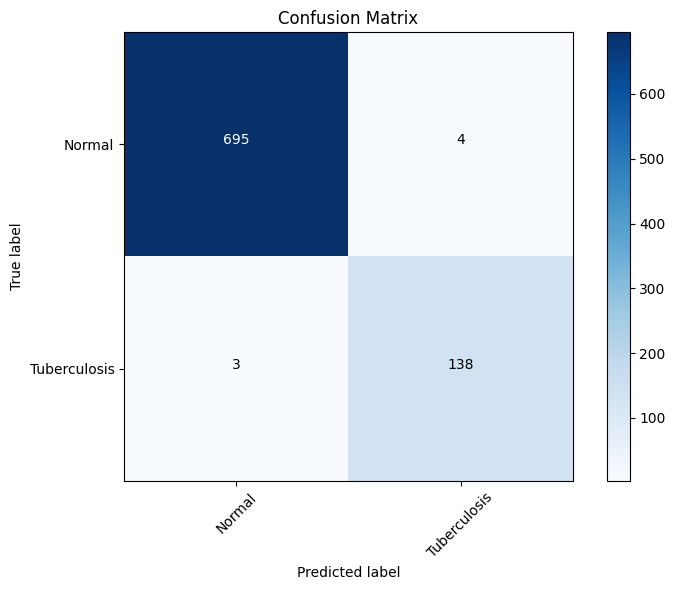

In [24]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [25]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 99.1667
Precision: 97.1831
Recall: 97.8723
F-Score: 97.5265


In [27]:
# real images
history = model.fit(
    X_train_real, 
    y_train, 
    epochs=50, 
    batch_size=16, 
    validation_data=(X_val_rgb, y_val), 
    class_weight=class_weights, 
    callbacks=[lr_scheduler]
)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9766 - loss: 0.0580 - precision_1: 0.9766 - recall_1: 0.9766 - val_accuracy: 0.9851 - val_loss: 0.0584 - val_precision_1: 0.9851 - val_recall_1: 0.9851 - learning_rate: 1.0000e-06
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9759 - loss: 0.0639 - precision_1: 0.9759 - recall_1: 0.9759 - val_accuracy: 0.9881 - val_loss: 0.0586 - val_precision_1: 0.9881 - val_recall_1: 0.9881 - learning_rate: 1.0000e-06
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.9765 - loss: 0.0571 - precision_1: 0.9765 - recall_1: 0.9765 - val_accuracy: 0.9866 - val_loss: 0.0587 - val_precision_1: 0.9866 - val_recall_1: 0.9866 - learning_rate: 1.0000e-06
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9768 - loss: 0.0651 - precision_1: 0.9768 - recall_1: 0.9768 - val_accuracy: 0.9866 - val_loss: 0.0573 - val_precision_1: 0.9866 - val_recall_1: 0.9866 - learning_rate: 1.0000e-06
Epoch 5/50
1

27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


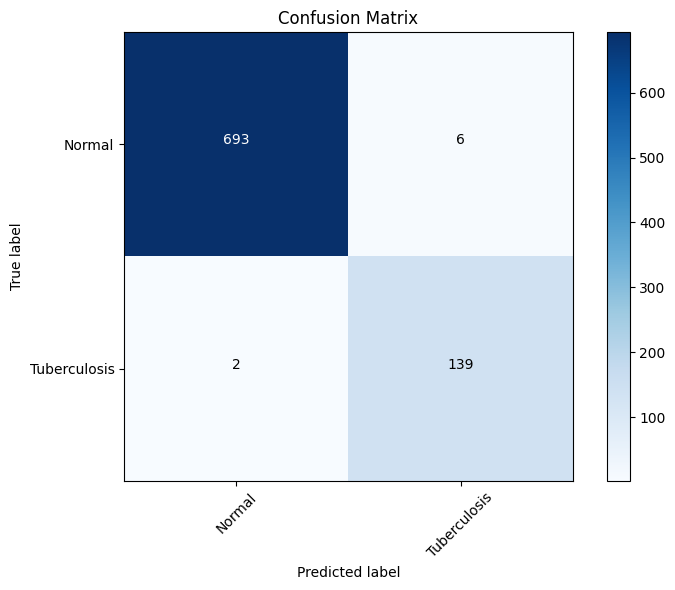

In [28]:
y_pred = model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)

true_classes = y_test  

categories = ["Normal", "Tuberculosis"]

conf_matrix = confusion_matrix(true_classes, y_pred_classes, labels=range(len(categories)))

plt.figure(figsize=(8, 6))  
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45)
plt.yticks(tick_marks, categories)

fmt = 'd'
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [29]:
tp = conf_matrix[1,1]
fp = conf_matrix[0,1]
tn = conf_matrix[0,0]
fn = conf_matrix[1,0]

# Calculate accuracy precision and recall
Accuracy = (tp+tn)/(tp+fp+tn+fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F_Score = 2*((precision*recall)/(precision+recall))

print('Accuracy:', np.round(Accuracy *100,4))
print('Precision:', np.round(precision*100,4))
print('Recall:', np.round(recall*100,4))
print('F-Score:', np.round(F_Score*100,4))

Accuracy: 99.0476
Precision: 95.8621
Recall: 98.5816
F-Score: 97.2028


In [30]:
#model.save(os.path.join('models','resnet50-aug.h5'))
import datetime
datetime_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f"inception_resnet_v2-{datetime_str}.h5"

model.save(filename)

ValueError: Unable to synchronously create dataset (name already exists)